# CVPack Demo: Collective Variables for Molecular Dynamics

Welcome to this demonstration of **CVPack**, a powerful Python library for defining and using collective variables in molecular dynamics simulations with OpenMM.

## What You'll Learn

In this demo, we'll explore:
- 🧬 Setting up a simple molecular system (alanine dipeptide)
- 📊 Defining collective variables (φ and ψ dihedral angles)
- 🔬 Running MD simulations with CV monitoring
- 📈 Analyzing and visualizing the results

---

## Prerequisites & Installation

To run this demo, you'll need to install the required dependencies:

```bash
conda create -n mm_env python=3.12
conda activate mm_env
conda config --add channels conda-forge
conda config --add channels mdtools
conda install openmm mdtraj openmmtools ufedmm tqdm
```

**Note:** `cvpack` is automatically installed as a dependency of `ufedmm`.

---

## Import Required Libraries

In [1]:
import io
import numpy as np

import openmm as mm
from openmm import app, unit
import pandas as pd

import cvpack
from cvpack import reporting
import mdtraj

from tqdm.auto import tqdm

---

## 1. System Setup: Alanine Dipeptide

We'll use **alanine dipeptide** as our test system - a classic model peptide that's perfect for demonstrating collective variables. This small molecule contains the essential backbone structure found in proteins.


In [2]:
alanine_dipeptide_pdb = """
REMARK  ACE                                                         
ATOM      1 1HH3 ACE     1       2.000   1.000  -0.000
ATOM      2  CH3 ACE     1       2.000   2.090   0.000
ATOM      3 2HH3 ACE     1       1.486   2.454   0.890
ATOM      4 3HH3 ACE     1       1.486   2.454  -0.890
ATOM      5  C   ACE     1       3.427   2.641  -0.000
ATOM      6  O   ACE     1       4.391   1.877  -0.000
ATOM      7  N   ALA     2       3.555   3.970  -0.000
ATOM      8  H   ALA     2       2.733   4.556  -0.000
ATOM      9  CA  ALA     2       4.853   4.614  -0.000
ATOM     10  HA  ALA     2       5.408   4.316   0.890
ATOM     11  CB  ALA     2       5.661   4.221  -1.232
ATOM     12 1HB  ALA     2       5.123   4.521  -2.131
ATOM     13 2HB  ALA     2       6.630   4.719  -1.206
ATOM     14 3HB  ALA     2       5.809   3.141  -1.241
ATOM     15  C   ALA     2       4.713   6.129   0.000
ATOM     16  O   ALA     2       3.601   6.653   0.000
ATOM     17  N   NME     3       5.846   6.835   0.000
ATOM     18  H   NME     3       6.737   6.359  -0.000
ATOM     19  CH3 NME     3       5.846   8.284   0.000
ATOM     20 1HH3 NME     3       4.819   8.648   0.000
ATOM     21 2HH3 NME     3       6.360   8.648   0.890
ATOM     22 3HH3 NME     3       6.360   8.648  -0.890
TER   
END
"""

pdb = app.PDBFile(io.StringIO(alanine_dipeptide_pdb))

### Creating the OpenMM System

Now we'll create a molecular dynamics system using the AMBER force field. We're using vacuum conditions for faster sampling in this demo.


In [3]:
# Create the molecular system with force field
forcefield = app.ForceField("amber14-all.xml")

# Create the system - we'll use vacuum for faster sampling
system = forcefield.createSystem(
    pdb.topology,
    nonbondedMethod=app.NoCutoff,  # No cutoff for vacuum
    constraints=app.HBonds,  # Constrain bonds to hydrogen
)

print(f"System created with {system.getNumParticles()} particles")


def print_forces(system):
    df = pd.DataFrame(columns=["force", "class", "group"])
    for i in range(system.getNumForces()):
        f = system.getForce(i)
        df.loc[i] = [f.getName(), f.__class__.__name__, f.getForceGroup()]
    display(df)


print_forces(system)

System created with 22 particles


,force,class,group
0,HarmonicBondForce,HarmonicBondForce,0
1,PeriodicTorsionForce,PeriodicTorsionForce,0
2,NonbondedForce,NonbondedForce,0
3,CMMotionRemover,CMMotionRemover,0
4,HarmonicAngleForce,HarmonicAngleForce,0


### Setting Up the Simulation

We'll create a Langevin integrator for sampling at room temperature and minimize the initial structure.


In [4]:
# Create integrator and simulation context
temperature = 300 * unit.kelvin
friction = 1.0 / unit.picosecond
timestep = 2.0 * unit.femtosecond

integrator = mm.LangevinMiddleIntegrator(temperature, friction, timestep)

# Create the simulation context
simulation = app.Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

# Minimize energy
print("Minimizing energy...")
simulation.minimizeEnergy(maxIterations=100)

# Get initial state
state = simulation.context.getState(getPositions=True, getEnergy=True)
print(f"Initial potential energy: {state.getPotentialEnergy()}")

print("OpenMM context successfully created!")

Minimizing energy...
Initial potential energy: -86.16262817382812 kJ/mol
OpenMM context successfully created!


## 💡 **Key Concept: Force Groups**

**What are Force Groups?**
OpenMM organizes forces into numbered groups (0, 1, 2, ...). This allows selective control over which forces affect the dynamics:

- **Group 0**: Physical forces (bonds, angles, nonbonded interactions)  
- **Group 1+**: Collective variable forces (for monitoring or biasing)

**Why This Matters:**
- **Pure monitoring**: Exclude CV forces from integration → dynamics unaffected
- **Enhanced sampling**: Include CV forces → bias the simulation  
- **Flexibility**: Switch between free and biased sampling easily

🔧 **Technical Note:** For pure monitoring, CVs are added as forces but excluded from integration using force groups.

In [5]:
integrator.setIntegrationForceGroups({0})

---

## 2. Defining Collective Variables with CVPack

**What are Collective Variables?**

Collective variables (CVs) are functions of atomic coordinates that describe the slow, important degrees of freedom in molecular systems. For alanine dipeptide, the classic CVs are the **φ (phi)** and **ψ (psi)** backbone dihedral angles that define the protein's local conformation.

### Finding the Dihedral Angles

We'll use MDTraj to automatically identify the atoms involved in the φ and ψ angles:

In [6]:
# Create mdtraj trajectory for analysis
positions_array = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)
mdtraj_top = mdtraj.Topology.from_openmm(pdb.topology)
traj = mdtraj.Trajectory(positions_array, mdtraj_top)

# Use mdtraj's built-in functions to automatically find phi/psi atoms
phi_indices, phi_values = mdtraj.compute_phi(traj)
psi_indices, psi_values = mdtraj.compute_psi(traj)

print(f"φ atom indices: {phi_indices[0]} value: {phi_values[0][0]:6.3f} radians")
print(f"ψ atom indices: {psi_indices[0]} value: {psi_values[0][0]:6.3f} radians")

# φ: C(ACE) - N(ALA) - CA(ALA) - C(ALA)
# ψ: N(ALA) - CA(ALA) - C(ALA) - N(NME)

φ atom indices: [ 4  6  8 14] value: -2.666 radians
ψ atom indices: [ 6  8 14 16] value:  2.782 radians


### Creating CVPack Collective Variables

Now we'll create CVPack `Torsion` objects for our φ and ψ angles and add them to the OpenMM system:


In [7]:
print("Creating collective variables...")
phi = cvpack.Torsion(*phi_indices[0], name="phi")
psi = cvpack.Torsion(*psi_indices[0], name="psi")

# Add the collective variables to the system
phi.addToSystem(system)
psi.addToSystem(system)

print_forces(system)

Creating collective variables...


,force,class,group
0,HarmonicBondForce,HarmonicBondForce,0
1,PeriodicTorsionForce,PeriodicTorsionForce,0
2,NonbondedForce,NonbondedForce,0
3,CMMotionRemover,CMMotionRemover,0
4,HarmonicAngleForce,HarmonicAngleForce,0
5,phi,CustomTorsionForce,1
6,psi,CustomTorsionForce,2


### Understanding Effective Mass
 
The **effective mass** is a crucial property that quantifies how "sluggish" a collective variable (CV) is to change. It represents the inertia associated with the CV and is essential for enhanced sampling methods.


The effective mass a collective variable $q({\bf r})$ is given by:

$$
m_\mathrm{eff}({\bf r}) = \left(
    \sum_{i=1}^N \frac{1}{m_i} \left\| \frac{dq}{d{\bf r}_i} \right\|^2
\right)^{-1}
$$

where $m_i$ is the mass of atom $i$, $\mathbf{r}_i$ is its position, and the sum effectively accounts for all atoms involved in the CV.


**Note:** CVPack is the only OpenMM-based package that calculates effective masses systematically.

---


### Accessing CV Values and Properties

CVPack allows us to easily compute collective variable values and their effective masses during the simulation:


In [8]:
simulation.context.reinitialize(preserveState=True)

print(f"φ value: {phi.getValue(simulation.context)}")
print(f"ψ value: {psi.getValue(simulation.context)}")
print()
print(f"φ effective mass: {phi.getEffectiveMass(simulation.context)}")
print(f"ψ effective mass: {psi.getEffectiveMass(simulation.context)}")

φ value: -2.6657958030700684 rad
ψ value: 2.7821197509765625 rad

φ effective mass: 0.04270508233375121 nm**2 Da/(rad**2)
ψ effective mass: 0.049810710166637726 nm**2 Da/(rad**2)


---

## 3. Running the Simulation with CV Monitoring

### Setting Up CV Reporters

CVPack provides specialized reporters to track collective variable values during the simulation. We'll monitor both the CV values and their effective masses:


In [9]:
phi_writer = reporting.CVWriter(phi, value=True, emass=True)
psi_writer = reporting.CVWriter(psi, value=True, emass=True)

reporter = reporting.StateDataReporter(
    "output.csv",
    100,  # Report every 100 steps
    step=True,
    time=True,
    potentialEnergy=True,
    temperature=True,
    writers=[phi_writer, psi_writer],
)
simulation.reporters.append(reporter)

print("Running 50,000 steps (100 ps simulation)...")
for _ in tqdm(range(1000)):
    simulation.step(50)

Running 50,000 steps (100 ps simulation)...


  0%|          | 0/1000 [00:00<?, ?it/s]

### Loading and Examining the Results

Let's load our simulation data and examine what we've collected:


In [10]:
df = pd.read_csv("output.csv").rename({'#"Step"': "Step"}, axis=1)
df

,Step,Time (ps),Potential Energy (kJ/mole),Temperature (K),phi (rad),emass[phi] (nm**2 Da/(rad**2)),psi (rad),emass[psi] (nm**2 Da/(rad**2))
0,100,0.2,-75.873352,86.893642,-2.700812,0.044096,2.909213,0.052332
1,200,0.4,-72.753387,138.247970,-2.696945,0.044180,2.740032,0.050049
2,300,0.6,-65.736420,179.462189,-2.573398,0.041509,2.823624,0.046056
3,400,0.8,-62.999268,146.211367,-2.733951,0.042968,2.565873,0.048114
4,500,1.0,-53.141998,140.550850,-2.248099,0.035961,2.863393,0.052067
...,...,...,...,...,...,...,...,...
495,49600,99.2,-36.101471,251.406938,-1.524347,0.027228,1.164484,0.033767
496,49700,99.4,-32.183777,215.141683,-1.396178,0.027150,1.030715,0.023738
497,49800,99.6,-23.617065,244.213587,-1.160769,0.024305,0.782947,0.029397
498,49900,99.8,-23.586761,263.422072,-1.525452,0.032310,1.270606,0.029563


---

## 4. Analysis and Visualization

### Creating Publication-Quality Plots

Now for the exciting part! Let's visualize our simulation results with both time series and the famous **Ramachandran plot**:


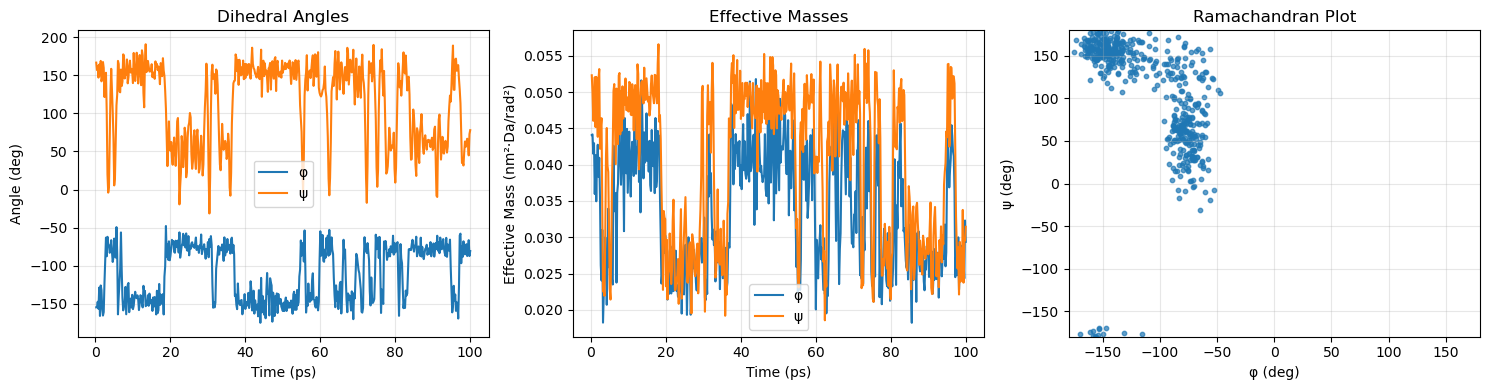

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def unwrap(angles):
    return np.unwrap(angles, period=360)


# Unwrap and convert angles to degrees
phi_deg = df["phi (rad)"] * 180 / np.pi
psi_deg = df["psi (rad)"] * 180 / np.pi
times = df["Time (ps)"]

# Extract effective masses
phi_emass = df["emass[phi] (nm**2 Da/(rad**2))"]
psi_emass = df["emass[psi] (nm**2 Da/(rad**2))"]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot time series
axs[0].plot(times, unwrap(phi_deg), label="φ")
axs[0].plot(times, unwrap(psi_deg), label="ψ")
axs[0].set_xlabel("Time (ps)")
axs[0].set_ylabel("Angle (deg)")
axs[0].set_title("Dihedral Angles")
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot effective masses
axs[1].plot(times, phi_emass, label="φ", color="C0")
axs[1].plot(times, psi_emass, label="ψ", color="C1")
axs[1].set_xlabel("Time (ps)")
axs[1].set_ylabel("Effective Mass (nm²⋅Da/rad²)")
axs[1].set_title("Effective Masses")
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Ramachandran plot (conformational space)
axs[2].scatter(phi_deg, psi_deg, s=10, alpha=0.7)
axs[2].set_xlabel("φ (deg)")
axs[2].set_ylabel("ψ (deg)")
axs[2].set_title("Ramachandran Plot")
axs[2].set_xlim(-180, 180)
axs[2].set_ylim(-180, 180)
axs[2].grid(True, alpha=0.3)
# Each point represents a sampled conformation

plt.tight_layout()
plt.show()

---

## 🎉 Congratulations!

You've successfully:

✅ **Set up a molecular dynamics system** with OpenMM and AMBER force fields  
✅ **Defined collective variables** using CVPack's intuitive interface  
✅ **Monitored CVs during simulation** with specialized reporters  
✅ **Analyzed the results** with time series and Ramachandran plots  

### What's Next?

With CVPack, you can explore many more collective variables:
- **Distance** measurements between atoms or groups
- **RMSD** from reference structures  
- **Radius of gyration** for compactness
- **Contact numbers** for binding studies
- **Custom functions** for specialized applications

### Learn More

- **CVPack Documentation**: Check the repository for detailed API documentation
- **OpenMM Documentation**: Available at the official OpenMM website
- **Enhanced Sampling Methods**: Explore computational chemistry literature for advanced techniques


---

## 5. Advanced CVPack: MetaCV and Enhanced Sampling

### What is a MetaCV?

A **Meta Collective Variable (MetaCV)** is one of CVPack's most powerful features. It allows you to:
- 🔗 **Combine multiple CVs** into complex mathematical expressions
- ⚡ **Apply biasing forces** for enhanced sampling
- 🎯 **Create restraints** to maintain desired conformations
- 📊 **Design custom reaction coordinates** for complex processes

### Creating a Harmonic Restraint

We'll demonstrate a practical use case: applying a **harmonic restraint** to the φ angle to keep it near its current value. This is useful for:
- Preventing large conformational changes
- Studying local fluctuations around a reference state
- Enhanced sampling with umbrella sampling


### Step 1: Calculate Optimal Spring Constant

For a stable harmonic restraint, we need to choose an appropriate spring constant based on the CV's effective mass:


In [12]:
# Check the mean effective mass of phi
phi_emass = df["emass[phi] (nm**2 Da/(rad**2))"].mean() * (
    unit.nanometer**2 * unit.dalton / unit.radian**2
)
print(f"Mean effective mass of phi: {phi_emass}")

# Set an oscillation period of 40 fs
oscillator_period = 0.04 * unit.picosecond

# Calculate spring constant: k = m * (2π/T)²
spring_constant = (phi_emass * (2 * np.pi / oscillator_period) ** 2).in_units_of(
    unit.kilojoules_per_mole / unit.radian**2
)
print(f"Spring constant kappa: {spring_constant}")

Mean effective mass of phi: 0.03364849841558963 nm**2 Da/(rad**2)
Spring constant kappa: 830.2434201313794 kJ/(mol rad**2)


### Step 2: Set Up a Clean System

We'll start fresh with a new system to demonstrate the MetaCV workflow clearly:


In [13]:
forcefield = app.ForceField("amber14-all.xml")

system = forcefield.createSystem(
    pdb.topology,
    nonbondedMethod=app.NoCutoff,  # No cutoff for vacuum
    constraints=app.HBonds,  # Constrain bonds to hydrogen
)

integrator = mm.LangevinMiddleIntegrator(
    300 * unit.kelvin,
    1.0 / unit.picosecond,
    2 * unit.femtosecond,
)

simulation = app.Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy(maxIterations=100)

# Print the system's potential energy after minimization
state = simulation.context.getState(getEnergy=True)
potential_energy = state.getPotentialEnergy()
print(f"Potential energy after minimization: {potential_energy}")

Potential energy after minimization: -86.16262817382812 kJ/mol


### Step 3: Create the MetaCV with Harmonic Restraint

Now we'll create a MetaCV that applies a harmonic potential to the φ angle. The mathematical form is:

$$V_{\text{restraint}}(\phi) = \frac{1}{2} \kappa \cdot \min(|\phi - \phi_0|, 2\pi - |\phi - \phi_0|)^2$$

This accounts for the **periodic nature** of dihedral angles!


In [14]:
# Create mdtraj trajectory for analysis
state = simulation.context.getState(getPositions=True)
positions_array = state.getPositions(asNumpy=True).value_in_unit(unit.nanometer)
mdtraj_top = mdtraj.Topology.from_openmm(pdb.topology)
traj = mdtraj.Trajectory(positions_array, mdtraj_top)

phi_indices, phi_values = mdtraj.compute_phi(traj)
psi_indices, psi_values = mdtraj.compute_psi(traj)

In [15]:
# Create fresh CV objects for the MetaCV
phi = cvpack.Torsion(*phi_indices[0], name="phi")
psi = cvpack.Torsion(*psi_indices[0], name="psi")

# Store reference values
phi_ref = phi_values[0][0]  # Reference φ angle
print(f"Reference φ angle: {phi_ref:.3f} rad ({phi_ref * 180 / np.pi:.1f}°)")
print(f"Spring constant: {spring_constant}")

# Create a MetaCV with periodic harmonic restraint
harmonic_restraint = cvpack.MetaCollectiveVariable(
    function=f"0.5 * kappa * (min(abs(phi-phi0), {2 * np.pi}-abs(phi-phi0)))^2",
    variables=[phi, psi],  # psi included for monitoring
    kappa=spring_constant,
    unit=unit.kilojoules_per_mole,
    phi0=phi_ref,
    name="harmonic_restraint",
)

# Add the MetaCV to the system
harmonic_restraint.addToSystem(system)
simulation.context.reinitialize(preserveState=True)

print_forces(system)

Reference φ angle: -2.666 rad (-152.7°)
Spring constant: 830.2434201313794 kJ/(mol rad**2)


,force,class,group
0,HarmonicBondForce,HarmonicBondForce,0
1,PeriodicTorsionForce,PeriodicTorsionForce,0
2,NonbondedForce,NonbondedForce,0
3,CMMotionRemover,CMMotionRemover,0
4,HarmonicAngleForce,HarmonicAngleForce,0
5,harmonic_restraint,CustomCVForce,1


### Step 4: Test the MetaCV

Let's verify that our MetaCV is working correctly before running the full simulation:


In [16]:
# Test the MetaCV functionality
print("Testing MetaCV components:")
print(f"Reference φ: {phi_ref:.3f} rad")
print(f"Restraint energy: {harmonic_restraint.getValue(simulation.context)}")

# Check the force is properly configured
state = simulation.context.getState(getEnergy=True)
print(f"Total potential energy: {state.getPotentialEnergy()}")

Testing MetaCV components:
Reference φ: -2.666 rad
Restraint energy: 0.0 kJ/mol
Total potential energy: -86.16262817382812 kJ/mol


### Step 5: Configure Force Groups for Biased Sampling

**Important:** Since we want the MetaCV to **actually apply forces** (unlike pure monitoring CVs), we need to include its force group in integration:


💡 **Key Insight:** Force group 0 = system forces, Force group 1 = MetaCV forces

In [17]:
# Configure integrator to include both physical forces (group 0) and MetaCV forces (group 1)
integrator.setIntegrationForceGroups({0, 1})
print("✅ Force groups configured: {0, 1}")

# Verify energy includes MetaCV contribution
state = simulation.context.getState(getEnergy=True)
print(f"Total potential energy (with MetaCV): {state.getPotentialEnergy()}")

# Compare individual force group contributions
physical_energy = simulation.context.getState(
    getEnergy=True, groups={0}
).getPotentialEnergy()
metacv_energy = simulation.context.getState(
    getEnergy=True, groups={1}
).getPotentialEnergy()
print(f"Physical forces energy: {physical_energy}")
print(f"MetaCV energy: {metacv_energy}")

✅ Force groups configured: {0, 1}
Total potential energy (with MetaCV): -86.16262817382812 kJ/mol
Physical forces energy: -86.16262817382812 kJ/mol
MetaCV energy: 0.0 kJ/mol


### Step 6: Run Biased Simulation with Enhanced Monitoring

Now we'll run a simulation where the φ angle is restrained around its reference value:


In [18]:
# Clear any existing reporters first
simulation.reporters.clear()

# Create specialized reporters for MetaCV analysis
harmonic_restraint_writer = reporting.CVWriter(
    harmonic_restraint, value=True, emass=True
)
inner_cv_writer = reporting.MetaCVWriter(
    harmonic_restraint, values=["phi", "psi"], emasses=["phi", "psi"]
)

reporter = reporting.StateDataReporter(
    "restraint_simulation.csv",
    100,  # Report every 100 steps
    step=True,
    time=True,
    potentialEnergy=True,
    temperature=True,
    writers=[harmonic_restraint_writer, inner_cv_writer],
)
simulation.reporters.append(reporter)

print("🚀 Running restrained simulation (100 ps)...")
print("The φ angle should remain close to its reference value!")
for _ in tqdm(range(1000)):
    simulation.step(50)

print("✅ Restrained simulation completed!")

🚀 Running restrained simulation (100 ps)...
The φ angle should remain close to its reference value!


  0%|          | 0/1000 [00:00<?, ?it/s]

✅ Restrained simulation completed!


### Step 7: Analyze Restrained Simulation Results

Let's examine how the harmonic restraint affected the simulation:


In [20]:
# Load restrained simulation data
df_restrained = pd.read_csv("restraint_simulation.csv").rename(
    {'#"Step"': "Step"}, axis=1
)

print("📊 Restrained Simulation Analysis:")
print(f"Simulation length: {len(df_restrained)} frames")
print(
    f"Time range: {df_restrained['Time (ps)'].min():.1f} - {df_restrained['Time (ps)'].max():.1f} ps"
)

# Analyze restraint effectiveness
phi_values = df_restrained["phi (rad)"]
phi_ref_deg = phi_ref * 180 / np.pi
phi_std = np.std(phi_values * 180 / np.pi)

print(f"\n🎯 Restraint Effectiveness:")
print(f"Reference φ: {phi_ref_deg:.1f}°")
print(f"φ standard deviation: {phi_std:.1f}°")
print(f"Maximum deviation: {np.max(np.abs(phi_values - phi_ref)) * 180 / np.pi:.1f}°")

# Show first few rows
print(f"\n📈 Sample data:")
df_restrained.head()

📊 Restrained Simulation Analysis:
Simulation length: 500 frames
Time range: 0.2 - 100.0 ps

🎯 Restraint Effectiveness:
Reference φ: -152.7°
φ standard deviation: 3.3°
Maximum deviation: 10.2°

📈 Sample data:


,Step,Time (ps),Potential Energy (kJ/mole),Temperature (K),harmonic_restraint (kJ/mol),emass[harmonic_restraint] (nm**2 mol**2 Da/(kJ**2)),phi (rad),psi (rad),emass[phi] (nm**2 Da/(rad**2)),emass[psi] (nm**2 Da/(rad**2))
0,100,0.2,-72.581052,63.212661,0.061405,0.000403,-2.653634,2.730290,0.041041,0.050182
1,200,0.4,-59.887755,113.358541,1.423097,0.000018,-2.724346,2.669240,0.041773,0.047561
2,300,0.6,-47.970954,127.603524,0.218835,0.000112,-2.642836,3.090697,0.040635,0.048327
3,400,0.8,-69.507105,234.422035,0.951880,0.000026,-2.617910,2.614879,0.040448,0.049127
4,500,1.0,-45.484821,224.711992,0.955181,0.000027,-2.713764,2.563304,0.042261,0.046484


### Step 8: Advanced Visualization - Comparing Free vs Restrained Dynamics

Let's create a comprehensive comparison showing the effect of the harmonic restraint:


📊 Comparing with free simulation data


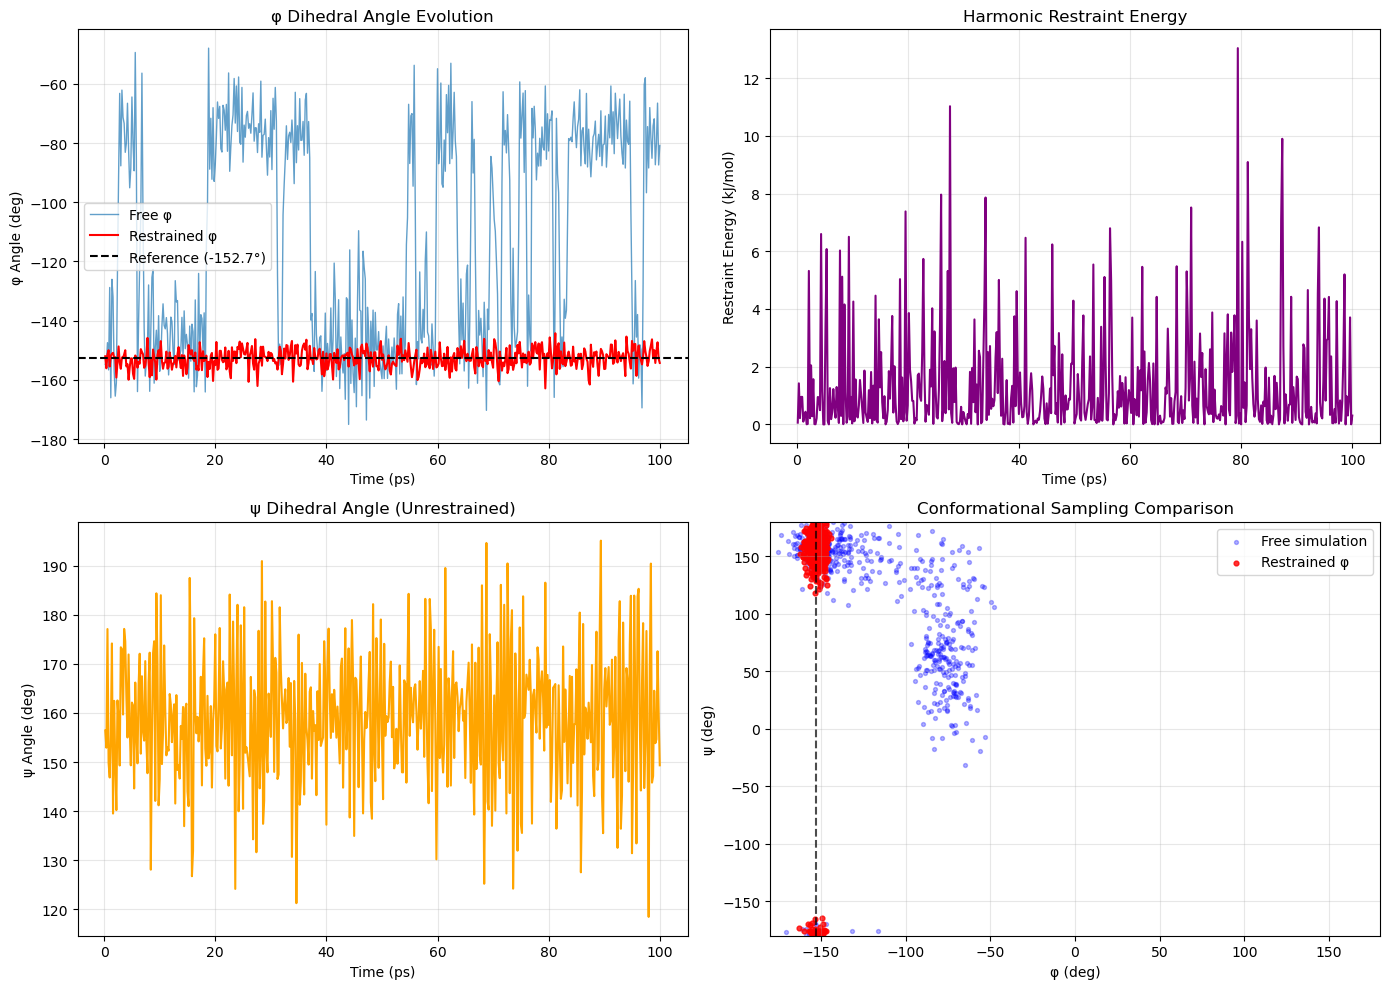


📈 **MetaCV Demonstration Summary:**
✅ Harmonic restraint successfully applied to φ angle
🎯 φ angle kept within ±3.3° of reference
⚡ Average restraint energy: 1.34 kJ/mol
🔄 ψ angle remained free to sample: 81.0° std dev


In [21]:
import matplotlib.pyplot as plt

# Extract data for restrained simulation
times_rest = df_restrained["Time (ps)"]
phi_rest_deg = df_restrained["phi (rad)"] * 180 / np.pi
psi_rest_deg = df_restrained["psi (rad)"] * 180 / np.pi
restraint_energy = df_restrained["harmonic_restraint (kJ/mol)"]

# Load original free simulation for comparison
df_free = pd.read_csv("output.csv").rename({'#"Step"': "Step"}, axis=1)
phi_free_deg = df_free["phi (rad)"] * 180 / np.pi
psi_free_deg = df_free["psi (rad)"] * 180 / np.pi
times_free = df_free["Time (ps)"]
print("📊 Comparing with free simulation data")

# Create comprehensive visualization
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. φ angle comparison
axs[0, 0].plot(times_free, unwrap(phi_free_deg), label="Free φ", alpha=0.7, linewidth=1)
axs[0, 0].plot(
    times_rest,
    unwrap(phi_rest_deg),
    label="Restrained φ",
    color="red",
    linewidth=1.5,
)
axs[0, 0].axhline(
    phi_ref_deg, color="black", linestyle="--", label=f"Reference ({phi_ref_deg:.1f}°)"
)
axs[0, 0].set_xlabel("Time (ps)")
axs[0, 0].set_ylabel("φ Angle (deg)")
axs[0, 0].set_title("φ Dihedral Angle Evolution")
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# 2. Restraint energy over time
axs[0, 1].plot(times_rest, restraint_energy, color="purple", linewidth=1.5)
axs[0, 1].set_xlabel("Time (ps)")
axs[0, 1].set_ylabel("Restraint Energy (kJ/mol)")
axs[0, 1].set_title("Harmonic Restraint Energy")
axs[0, 1].grid(True, alpha=0.3)

# 3. ψ angle (free to move)
axs[1, 0].plot(times_rest, unwrap(psi_rest_deg), color="orange", linewidth=1.5)
axs[1, 0].set_xlabel("Time (ps)")
axs[1, 0].set_ylabel("ψ Angle (deg)")
axs[1, 0].set_title("ψ Dihedral Angle (Unrestrained)")
axs[1, 0].grid(True, alpha=0.3)

# 4. Restrained vs Free Ramachandran plots
axs[1, 1].scatter(
    phi_free_deg, psi_free_deg, s=8, alpha=0.3, label="Free simulation", color="blue"
)

axs[1, 1].scatter(
    phi_rest_deg, psi_rest_deg, s=12, alpha=0.8, label="Restrained φ", color="red"
)
axs[1, 1].axvline(phi_ref_deg, color="black", linestyle="--", alpha=0.7)
axs[1, 1].set_xlabel("φ (deg)")
axs[1, 1].set_ylabel("ψ (deg)")
axs[1, 1].set_title("Conformational Sampling Comparison")
axs[1, 1].set_xlim(-180, 180)
axs[1, 1].set_ylim(-180, 180)
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📈 **MetaCV Demonstration Summary:**")
print(f"✅ Harmonic restraint successfully applied to φ angle")
print(f"🎯 φ angle kept within ±{phi_std:.1f}° of reference")
print(f"⚡ Average restraint energy: {restraint_energy.mean():.2f} kJ/mol")
print(f"🔄 ψ angle remained free to sample: {psi_rest_deg.std():.1f}° std dev")

---

## 🎉 Congratulations! 

You've successfully explored **two powerful CVPack features**:

### ✅ **Part 1: Basic Collective Variables**
- 🧬 Set up molecular dynamics with OpenMM
- 📊 Defined φ and ψ dihedral angle CVs  
- 🔬 Monitored CV evolution during simulation
- 📈 Analyzed results with Ramachandran plots

### ✅ **Part 2: Advanced MetaCV Applications**  
- 🔗 Created a MetaCV combining multiple variables
- ⚡ Applied harmonic restraints for enhanced sampling
- 🎯 Demonstrated selective biasing (φ restrained, ψ free)
- 📊 Compared free vs restrained dynamics

### 🚀 **What's Next?**

With CVPack, you can now explore:
- **🌟 Free Energy Calculations** with umbrella sampling
- **🔄 Enhanced Sampling Methods** (metadynamics, adaptive biasing)
- **📐 Complex Reaction Coordinates** using multiple CVs
- **🧬 Protein Folding Studies** with custom CVs
- **💊 Drug Binding Analysis** with distance and RMSD CVs

### 📚 **Learn More**

- 📖 **CVPack Documentation**: Check the repository for detailed API documentation
- 🔬 **OpenMM Documentation**: Available at the official OpenMM website
- 📊 **Enhanced Sampling Methods**: Explore computational chemistry literature for advanced techniques

*Happy simulating with CVPack!* 🧬⚡🎯
